# Spaceship Titanic - A Supervised Classification Machine Learning Problem

# Background: 
Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!

![Planetary Systems](./Images/55_Cancri_E_from_Earth.png)

# File and Data Field Descriptions
**Personal records recovered from the ship's damaged computer system**
* **train.csv** - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.
    - PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
    - HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
    - CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
    - Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
    - Destination - The planet the passenger will be debarking to.
    - Age - The age of the passenger.
    - VIP - Whether the passenger has paid for special VIP service during the voyage.
    - RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
    - Name - The first and last names of the passenger.
    - Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.
* **test.csv** - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.
* **sample_submission.csv** - A submission file in the correct format.
    - PassengerId - Id for each passenger in the test set.
    - Transported - The target. For each passenger, predict either True or False.

### Define the Problem: 
1. What is the problem
    * Informal Description - I need a program that will predict which passengers were transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly using a set of personal records recovered from the ship's damaged computer system. <br><br>
    * Formalism 
        * Task(T) Classify a passenger (not seen in training) as being Transported ("True or False")
        * Experience(E) A list of passengers' personal records (the training set) indicating if they were Transported ("True or False") (Supervised Learning)
        * Performance(P) Classification accuracy, the number of passengers predicted correctly out of all passengers considered as a percentage<br><br>
2. Why does the problem need to be solved?
    * Motivation - I am solving this problem as a learning exercise in applying Machine Learning techniques.
    * Solution Use - The solution's lifetime is short-lived and will be submitted for the Kaggle competition (no maintenance required)<br><br>
3. How would I solve the problem?<br><br>
    * In a systematic fashion using a checklist<br><br>
source: https://machinelearningmastery.com/machine-learning-checklist/<br><br>
![ML Process to solve the problem](./Images/Machine-Learning-for-Programmers-Select-Tools-e1439699936331.png)
    * Define the Problem
    * Prepare the Data: Data Cleaning and Imputing missing values
    * Spot Check Algorithms: Baseline with simple model(s) to gain inital insight (i.e., feature importances) and benchmark classification accuracy (i.e., LogisticRegressionClassifier and RandomForestClassifier)
    * Improve the Results: Train and evaluate more complex models (like Deep Neural Networks) to improve classification accuracy
    * Present the Results


#### Assumptions:
    * A passenger's location on the ship when the collision occured matters to the model
        Related factors include:
            - Where is the passenger's cabin on the ship? Side, Deck, Cabin_Number
            - Was the passenger in their cabin at the time of the collision? Spending records indicate activity
            - What was the passenger's Destination? Passengers about to debark were likely not in their cabin
            - What was the passenger's HomePlanet? Passengers who recently embarked were likely in their cabin

### Prepare the Data:
#### Import Dependencies

In [1]:
# import common dependencies
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import seaborn and set_theme
import seaborn as sns
sns.set_theme(style="whitegrid")

# import regular expressions
import re

In [2]:
# sklearn dependencies
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay


In [3]:
# import dependencies from tensorflow
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

#### Extract the Data

In [4]:
# import training and testing csv files from Data folder
input_file_path = "./Data/clean_train_passenger_list.csv"
training_df = pd.read_csv(input_file_path)
training_df.shape

(6606, 17)

#### Set PassengerId as the index
The PassengerId is a unique value and is required as part of the contest submission. The PassengerId will be set as the index using set_index method so that any data cleaning retains the PassengerId value

In [5]:
training_df.set_index('PassengerId' , inplace=True, drop=True)
training_df

,GroupId,Group_Size,HomePlanet,Destination,Side,Deck,Cabin_Number,Age,CryoSleep,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
PassengerId,,,,,,,,,,,,,,,,
0001_01,1,1,1,2,0,1,0,39.0,0,0,0.0,0.0,0.0,0.0,0.0,0
0002_01,2,1,0,2,1,5,0,24.0,0,0,109.0,9.0,25.0,549.0,44.0,1
0003_01,3,2,1,2,1,0,0,58.0,0,1,43.0,3576.0,0.0,6715.0,49.0,0
0003_02,3,2,1,2,1,0,0,33.0,0,0,0.0,1283.0,371.0,3329.0,193.0,0
0004_01,4,1,0,2,1,5,1,16.0,0,0,303.0,70.0,151.0,565.0,2.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9276_01,9276,1,1,0,0,0,98,41.0,0,1,0.0,6819.0,0.0,1643.0,74.0,0
9278_01,9278,1,0,1,1,6,1499,18.0,1,0,0.0,0.0,0.0,0.0,0.0,0
9279_01,9279,1,0,2,1,6,1500,26.0,0,0,0.0,0.0,1872.0,1.0,0.0,1


In [6]:
# check dytpes and missing values
training_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6606 entries, 0001_01 to 9280_02
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   GroupId       6606 non-null   int64  
 1   Group_Size    6606 non-null   int64  
 2   HomePlanet    6606 non-null   int64  
 3   Destination   6606 non-null   int64  
 4   Side          6606 non-null   int64  
 5   Deck          6606 non-null   int64  
 6   Cabin_Number  6606 non-null   int64  
 7   Age           6606 non-null   float64
 8   CryoSleep     6606 non-null   int64  
 9   VIP           6606 non-null   int64  
 10  RoomService   6606 non-null   float64
 11  FoodCourt     6606 non-null   float64
 12  ShoppingMall  6606 non-null   float64
 13  Spa           6606 non-null   float64
 14  VRDeck        6606 non-null   float64
 15  Transported   6606 non-null   int64  
dtypes: float64(6), int64(10)
memory usage: 877.4+ KB


<AxesSubplot:ylabel='PassengerId'>

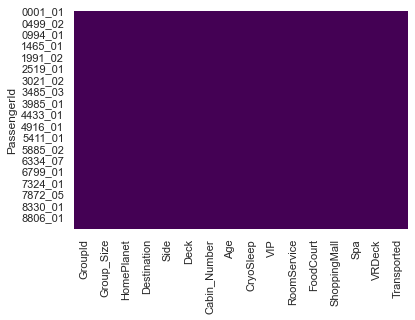

In [7]:
# visualize the missing values using seaborn heatmap
sns.heatmap(training_df.isnull(), cbar=False, cmap='viridis')

#### Explore the Data
##### What are the value counts for the Target (Transported)?
Is this a balanced or imbalanced problem? Balanced

In [8]:
# Examine the target variable "Transported"
Target = training_df["Transported"].value_counts()
Target

1    3327
0    3279
Name: Transported, dtype: int64

<AxesSubplot:>

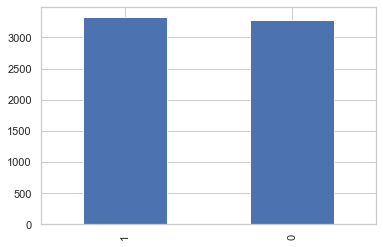

In [9]:
# visualize the value count of the Target
Target.plot(kind='bar')

### Split data into feature matrix (X) and target (y)

In [11]:
# Create feature matrix
X = training_df.drop(columns='Transported')
X.shape

(6606, 15)

In [12]:
# Create the target
y = training_df['Transported']
y.shape

(6606,)

### Split out a training and testing set

In [13]:
# from sklearn.model_selection import train_test_split 
# note: y is not scaled but the extension _ss is added to help me remember to use the scaled feature matrix values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

### StandarScaler: Transform the feature matrix using standard scaler 

In [14]:
# scale X_encoded using StandardScaler
data_scaler = StandardScaler()

In [15]:
# fit the data_scaler on X_train dataset
X_encoded = data_scaler.fit(X_train)
X_train_encoded = X_encoded.transform(X_train)
X_test_encoded = X_encoded.transform(X_test)

# examine the first row of X_train_encoded
X_train_encoded[:1]

array([[ 0.5133284 ,  2.64972365, -0.84620027,  0.62937615,  0.98278839,
         0.96317707,  0.75931205, -1.65322274, -0.73806901, -0.15620605,
        -0.34169532, -0.2898305 , -0.3082363 , -0.27858432, -0.26873829]])

### Establish a Baseline for model performance using LogisticRegress as a classifier

In [16]:
# Instantiate a Logistic Regression Model
# increased max_iter=1000 due to inability of 'lbfgs' solver to converge
LR_clf_baseline = LogisticRegression(solver='lbfgs', random_state=1, max_iter=100)
LR_clf_baseline

LogisticRegression(random_state=1)

In [17]:
# fit our model with our data (training)
LR_clf_baseline.fit(X_train_encoded, y_train)

LogisticRegression(random_state=1)

In [18]:
# create predictions using predict() method
y_pred_baseline = LR_clf_baseline.predict(X_test_encoded)
y_pred_baseline

array([0, 1, 1, ..., 1, 1, 1], dtype=int64)

In [19]:
# view the data
pd.DataFrame({"Prediction": y_pred_baseline, "Actual": y_test})

,Prediction,Actual
PassengerId,,
5967_03,0,0
8791_01,1,0
1368_01,1,0
3468_01,1,1
4897_01,0,0
...,...,...
1365_01,0,0
7790_02,0,0
7710_01,1,1


In [20]:
# calculate model accuracy
accuracy_score(y_test, y_pred_baseline)

0.7929782082324455

In [21]:
# create a confusion matrix
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
print(cm_baseline)

[[611 201]
 [141 699]]


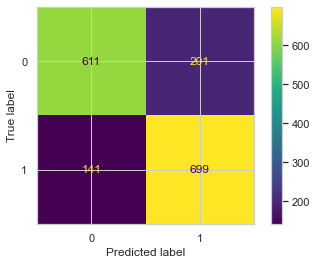

In [22]:
# confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm_baseline,display_labels= LR_clf_baseline.classes_)
disp.plot()

# save the image
plt.savefig("./Images/Baseline_confusion_matrix.png")
plt.show()

In [23]:
# view the classification report
# report = classification_report(y_test, y_pred_baseline, output_dict=True)

baseline_report = classification_report(y_test, y_pred_baseline)
print("Baseline")
print(baseline_report)

Baseline
              precision    recall  f1-score   support

           0       0.81      0.75      0.78       812
           1       0.78      0.83      0.80       840

    accuracy                           0.79      1652
   macro avg       0.79      0.79      0.79      1652
weighted avg       0.79      0.79      0.79      1652



### Random Forest Classifier


In [24]:
# model fit predict using the RandomForestClassifier

# model
rf_clf = RandomForestClassifier(n_estimators= 100,random_state=1)

# fit
rf_clf = rf_clf.fit(X_train_encoded, y_train)

# predict
y_pred_rf_clf = rf_clf.predict(X_test_encoded)

In [25]:
# Calculated the accuracy score
print(f"The accuracy score is: {accuracy_score(y_test, y_pred_rf_clf):.3f}")

The accuracy score is: 0.788


In [26]:
# Display the confusion matrix
cm_rf_clf = confusion_matrix(y_test, y_pred_rf_clf)
cm_rf_clf

array([[660, 152],
       [199, 641]], dtype=int64)

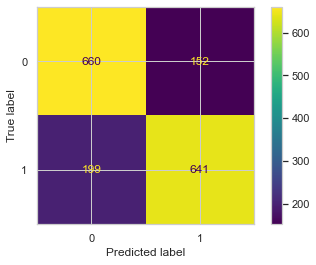

In [27]:
# confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf_clf,display_labels= rf_clf.classes_)
disp.plot()

# save the image
plt.savefig("./Images/RandomForestClassifier_confusion_matrix.png")
plt.show()

In [28]:
# Print the classification report
RandomForestClassifier_report = classification_report(y_test, y_pred_rf_clf)
print("RandomForestClassifier")
print(RandomForestClassifier_report)

RandomForestClassifier
              precision    recall  f1-score   support

           0       0.77      0.81      0.79       812
           1       0.81      0.76      0.79       840

    accuracy                           0.79      1652
   macro avg       0.79      0.79      0.79      1652
weighted avg       0.79      0.79      0.79      1652



In [29]:
# List the features sorted in descending order by feature importance
importance_features = rf_clf.feature_importances_

# put this together in a dataframe
# get the column names
cols = X.columns

# create the dataframe
importance_features_df = pd.DataFrame({'feature': cols, 'importance': importance_features})
importance_features_df

,feature,importance
0,GroupId,0.108727
1,Group_Size,0.033035
2,HomePlanet,0.031467
3,Destination,0.023353
4,Side,0.020259
5,Deck,0.047360
6,Cabin_Number,0.112612
7,Age,0.100580
8,CryoSleep,0.097322
9,VIP,0.001803


In [30]:
# sort in desc order
print("Feature Importance RandomForestClassifier")
top_ten_importance_features_df = importance_features_df.sort_values('importance', ascending=False)
top_ten_importance_features_df.reset_index(drop=True, inplace=True)
top_ten_importance_features_df

Feature Importance RandomForestClassifier


,feature,importance
0,Cabin_Number,0.112612
1,GroupId,0.108727
2,Age,0.100580
3,Spa,0.097578
4,CryoSleep,0.097322
5,RoomService,0.096351
6,VRDeck,0.086903
7,FoodCourt,0.076279
8,ShoppingMall,0.066369
9,Deck,0.047360


### Easy Ensemble AdaBoost Classifier

In [31]:
# Train the EasyEnsembleClassifier

# model
Ada_clf = AdaBoostClassifier(n_estimators=100, random_state=1)

# fit/train
Ada_clf.fit(X_train_encoded, y_train)

# predict
y_pred_Ada_clf = Ada_clf.predict(X_test_encoded)

In [32]:
# Calculated the accuracy score
accuracy_score(y_test, y_pred_Ada_clf)

0.7960048426150121

In [33]:
# Display the confusion matrix
cm_AdaBoost = confusion_matrix(y_test, y_pred_Ada_clf)
cm_AdaBoost

array([[610, 202],
       [135, 705]], dtype=int64)

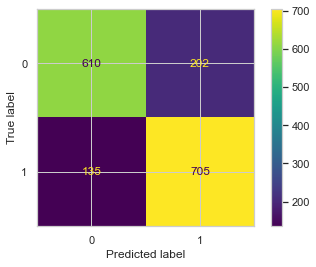

In [34]:
# confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm_AdaBoost,display_labels= Ada_clf.classes_)
disp.plot()

# save the image
plt.savefig("./Images/AdaBoostClassifier_confusion_matrix.png")
plt.show()

In [35]:
# Print the classification report
AdaBoostClassifier_classification_report = classification_report(y_test, y_pred_Ada_clf)
print("EasyEnsembleClassifier")
print(AdaBoostClassifier_classification_report)

EasyEnsembleClassifier
              precision    recall  f1-score   support

           0       0.82      0.75      0.78       812
           1       0.78      0.84      0.81       840

    accuracy                           0.80      1652
   macro avg       0.80      0.80      0.80      1652
weighted avg       0.80      0.80      0.80      1652



## Neural Network

* Define the model.
* Add first and second hidden layers.
* Add the output layer.

In [36]:
# how many inputs in the input layer
inputs = len(X_train_encoded[0])
print(f"There are {inputs} inputs")

There are 15 inputs


### Compile the model

In [37]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = inputs
hidden_nodes_layer1 = inputs * 3
hidden_nodes_layer2 = inputs * 2
hidden_nodes_layer3 = inputs * 1

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="sigmoid"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="sigmoid"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 45)                720       
_________________________________________________________________
dense_1 (Dense)              (None, 30)                1380      
_________________________________________________________________
dense_2 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 16        
Total params: 2,581
Trainable params: 2,581
Non-trainable params: 0
_________________________________________________________________


### Implement Checkpoints
Note: Create a callback that saves the model's weights every 5 epochs.

In [38]:
# Import checkpoint dependencies
# import os
# from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint path and filenames
os.makedirs("Checkpoints/",exist_ok=True)
checkpoint_path = "checkpoints/weights.{epoch:02d}.hdf5"

### Compile the Model

In [39]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [40]:
# Create a callback that saves the model's weights every epoch (set  5)
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq= 5)

In [41]:
len(X_train_encoded[0])

15

In [42]:
print(X_train_encoded.shape,
      y_train.shape,
      X_test_encoded.shape,
      y_test.shape
     )

(4954, 15) (4954,) (1652, 15) (1652,)


In [43]:
# Train the model
fit_model = nn.fit(X_train_encoded,y_train,epochs=50, callbacks=[cp_callback])

Epoch 1/50
  1/155 [..............................] - ETA: 54s - loss: 1.0861 - accuracy: 0.4062
Epoch 00001: saving model to checkpoints\weights.01.hdf5

Epoch 00001: saving model to checkpoints\weights.01.hdf5

Epoch 00001: saving model to checkpoints\weights.01.hdf5

Epoch 00001: saving model to checkpoints\weights.01.hdf5

Epoch 00001: saving model to checkpoints\weights.01.hdf5
 26/155 [====>.........................] - ETA: 0s - loss: 0.8403 - accuracy: 0.5036 
Epoch 00001: saving model to checkpoints\weights.01.hdf5

Epoch 00001: saving model to checkpoints\weights.01.hdf5

Epoch 00001: saving model to checkpoints\weights.01.hdf5

Epoch 00001: saving model to checkpoints\weights.01.hdf5

Epoch 00001: saving model to checkpoints\weights.01.hdf5
 51/155 [========>.....................] - ETA: 0s - loss: 0.7818 - accuracy: 0.4945
Epoch 00001: saving model to checkpoints\weights.01.hdf5

Epoch 00001: saving model to checkpoints\weights.01.hdf5

Epoch 00001: saving model to checkpoin

<AxesSubplot:>

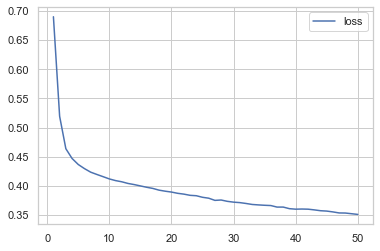

In [44]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))

# Plot the loss
history_df.plot(y="loss")

<AxesSubplot:>

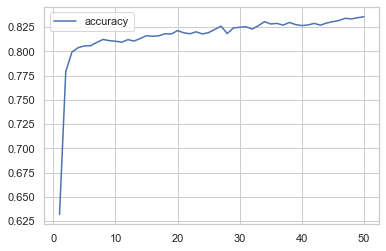

In [45]:
# Plot the accuracy
history_df.plot(y="accuracy")

In [46]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_encoded, y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

52/52 - 0s - loss: 0.4033 - accuracy: 0.8069
Loss: 0.40333738923072815, Accuracy: 0.8069007396697998


In [47]:
# Export our model to HDF5 file
nn.save("./Trained_Models/DeepNeuralNetwork.h5")

### Import model (check)

In [48]:
# Import the model to a new object
nn_imported = tf.keras.models.load_model('./Trained_Models/DeepNeuralNetwork.h5')

### Evaluate the model (again as a check) using test data

In [49]:
# Evaluate the completed model using the test data
model_loss, model_accuracy = nn_imported.evaluate(X_test_encoded,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

52/52 - 0s - loss: 0.4033 - accuracy: 0.8069
Loss: 0.40333738923072815, Accuracy: 0.8069007396697998


In [50]:
nn_imported.predict(X_test)

array([[0.08716792],
       [0.08716792],
       [0.08716792],
       ...,
       [0.16087696],
       [0.08716792],
       [0.13079059]], dtype=float32)